# Contents

* 1 Introduction
* 2 Importing Libraries
    * 2.1 Displaying Images
* 3 Model from scratch
    * 3.1 Making Training and Validation Data
    * 3.2 Model building
    * 3.3 Fitting the Model with Training and Validation Data
    * 3.4 Accuracy & Loss and Confusion Matrix
* 4 Transfer Learning with MobileNetV2
    * 4.1 Defining training and validation sets
    * 4.2 Model with changed output layer
        * 4.2.1 Accuracy & Loss and Confusion Matrix
    * 4.3 Model with extra layers added
        * 4.3.1 Accuracy & Loss and Confusion Matrix
    * 4.4 Fine-tuning final layers
        * 4.4.1 Accuracy & Loss and Confusion Matrix
* 5 Conclusions
* 6 Reflektioner

# 1 Introduction

Creating a face emotion recognition model based on a CNN-model made from scratch with the Haar cascade front face classifier algorithm. As a comparison the pre-trained MobileNetV2 model is also used through Transfer learning.
To compare the two models a Streamlit-app will show both models in action with parallel video.

# 2 Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## 2.1 Displaying Images

In [2]:
picture_size = 48
folder_path = "./images/"

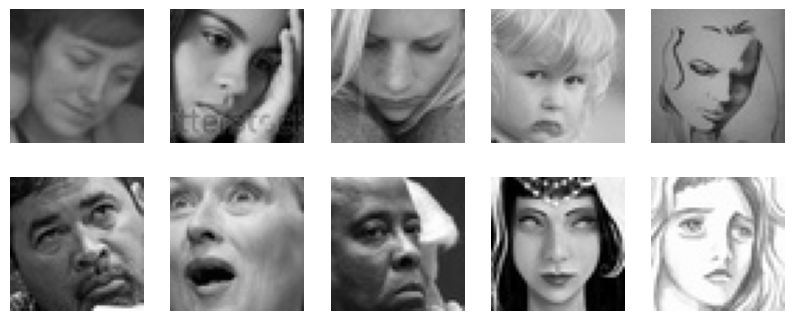

In [3]:
expression = 'sad'

plt.figure(figsize = (10, 4))
for i in range(1, 11, 1):
    plt.subplot(2, 5, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i],
                   target_size=(picture_size, picture_size))
    plt.axis("off")
    plt.imshow(img)
plt.show()

# 3 Model from scratch

## 3.1 Making Training and Validation Data

In [4]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

test_set = datagen_val.flow_from_directory(folder_path + "validation",
                                              target_size = (picture_size, picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## 3.2 Model Building

In [5]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, (5, 5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512, (3, 3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation = 'softmax'))


opt = Adam(learning_rate = 0.001)
model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

## 3.3 Fitting the Model with Training and Validation Data

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model.keras", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [7]:
history = model.fit(x = train_set,
                    steps_per_epoch = train_set.n//train_set.batch_size,
                    epochs = epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size,
                    callbacks = callbacks_list)

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.7941 - accuracy: 0.3095
Epoch 1: val_accuracy improved from -inf to 0.39886, saving model to model.keras
225/225 [==============================] - 327s 1s/step - loss: 1.7941 - accuracy: 0.3095 - val_loss: 1.5696 - val_accuracy: 0.3989 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.4317 - accuracy: 0.4482
Epoch 2: val_accuracy improved from 0.39886 to 0.44290, saving model to model.keras
225/225 [==============================] - 208s 924ms/step - loss: 1.4317 - accuracy: 0.4482 - val_loss: 1.5137 - val_accuracy: 0.4429 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.2807 - accuracy: 0.5094
Epoch 3: val_accuracy improved from 0.44290 to 0.49659, saving model to model.keras
225/225 [==============================] - 207s 920ms/step - loss: 1.2807 - accuracy: 0.5094 - val_loss: 1.3045 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 4/20
225/225 [==

## 3.4 Accuracy & Loss and Confusion Matrix

In [17]:
def plot_acc(model_history):
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize = 20)
    plt.ylabel('Loss', fontsize = 16)
    plt.plot(model_history.history['loss'], label = 'Training Loss')
    plt.plot(model_history.history['val_loss'], label = 'Validation Loss')
    plt.legend(loc = 'upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize = 16)
    plt.plot(model_history.history['accuracy'], label = 'Training Accuracy')
    plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.show()

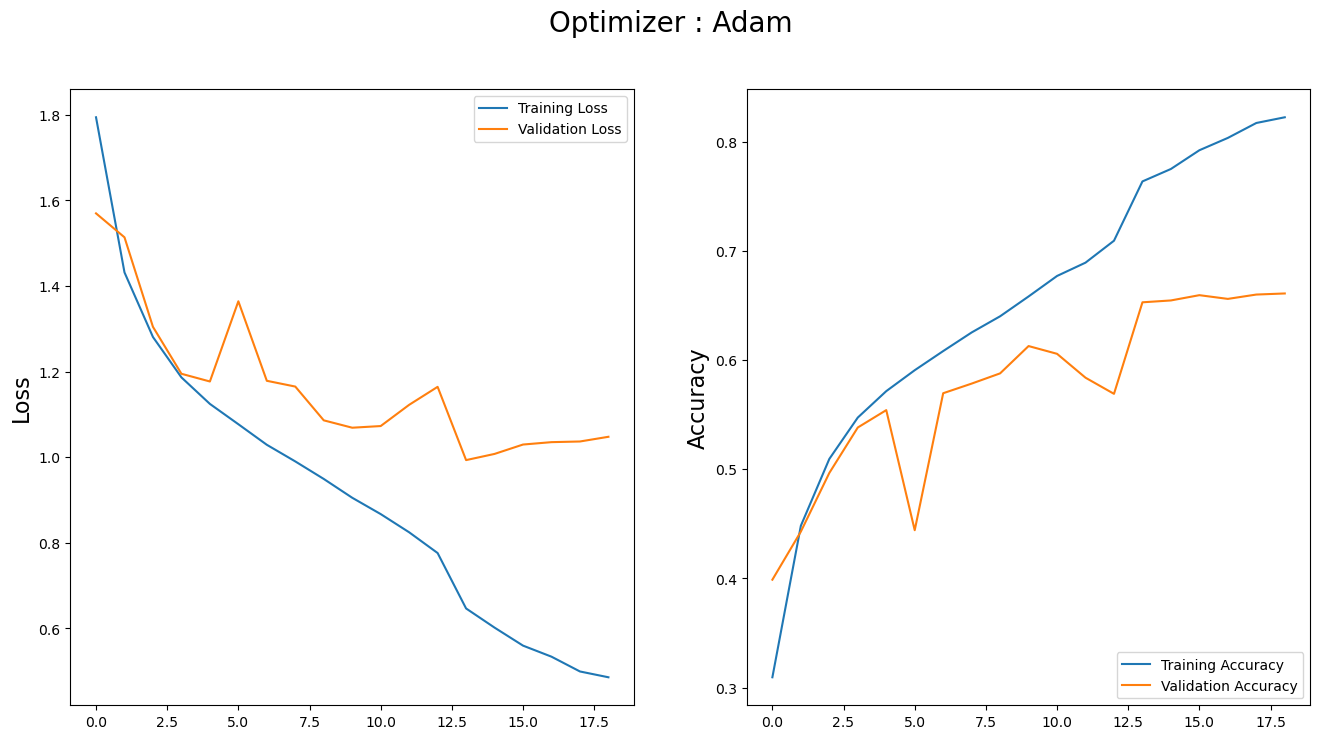

In [18]:
plot_acc(history)

In [ ]:
# model = load_model('model.keras')

In [9]:
y_test = test_set.classes
labels = test_set.class_indices.keys()

In [10]:
y_pred_prob_1 = model.predict(test_set)
y_pred_1 = np.argmax(y_pred_prob_1, axis = 1)
y_test = test_set.classes
labels = test_set.class_indices.keys()

56/56 [==============================] - 12s 212ms/step


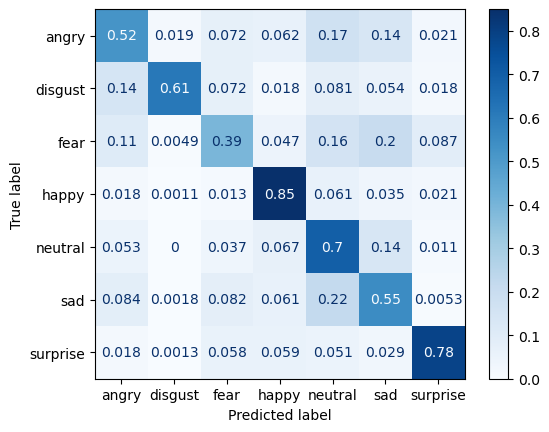

In [35]:
cm = confusion_matrix(y_test, y_pred_1, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap=plt.cm.Blues)

### Result

The result for the model is 66 % accuracy on the test set.

The Confusion Matrix shows that the model predicts the face exression "happy" correctly for 85 % of the test images. The expression "fear" is only predicted correctly for 39 % of the test images.

# 4 Transfer Learning with MobileNetV2

For comparison a pre-trained model will act as the base with some fine-tuning to adapt to the current task.
The base model in use is MobileNetV2 with 155 layers.

In [12]:
# importing libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Input

## 4.1 Defining training and validation sets

In [13]:
train_ds = image_dataset_from_directory(folder_path + "train",
                                        seed=123,
                                        label_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        image_size=(224, 224),
                                        batch_size=128)

test_ds = image_dataset_from_directory(folder_path + "validation",
                                       seed=123,
                                       label_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=False,
                                       image_size=(224, 224),
                                       batch_size=128)                                        

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


## 4.2 Model with changed output layer

In [14]:
base_model = MobileNetV2(include_top = False, pooling = 'avg')
base_model.trainable = False

In [15]:
# Model
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x)
outputs = Dense(no_of_classes, activation = 'softmax')(x)
model_2 = Model(inputs, outputs)


# compile
model_2.compile(loss='categorical_crossentropy',
                optimizer = Adam(learning_rate = 0.001),
                metrics=['accuracy'])

In [19]:
checkpoint_2 = ModelCheckpoint("model_2.keras", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list_2 = [early_stopping, checkpoint_2, reduce_learningrate]

history_2 = model_2.fit(x = train_ds,
                        steps_per_epoch = len(train_ds),
                        epochs = epochs,
                        validation_data = test_ds,
                        validation_steps = len(test_ds),
                        callbacks = callbacks_list_2)


Epoch 1/20
226/226 [==============================] - ETA: 0s - loss: 1.3207 - accuracy: 0.5062
Epoch 1: val_accuracy improved from -inf to 0.50948, saving model to model_2.keras
226/226 [==============================] - 314s 1s/step - loss: 1.3207 - accuracy: 0.5062 - val_loss: 1.3236 - val_accuracy: 0.5095 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - ETA: 0s - loss: 1.2971 - accuracy: 0.5111
Epoch 2: val_accuracy improved from 0.50948 to 0.51755, saving model to model_2.keras
226/226 [==============================] - 337s 1s/step - loss: 1.2971 - accuracy: 0.5111 - val_loss: 1.3051 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - ETA: 0s - loss: 1.2710 - accuracy: 0.5233
Epoch 3: val_accuracy did not improve from 0.51755
226/226 [==============================] - 342s 2s/step - loss: 1.2710 - accuracy: 0.5233 - val_loss: 1.3041 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 4/20
226/226 [==============================] - ETA

In [ ]:
# model_2 = load_model('model_2.keras')

### 4.2.1 Accuracy & Loss and Confusion Matrix

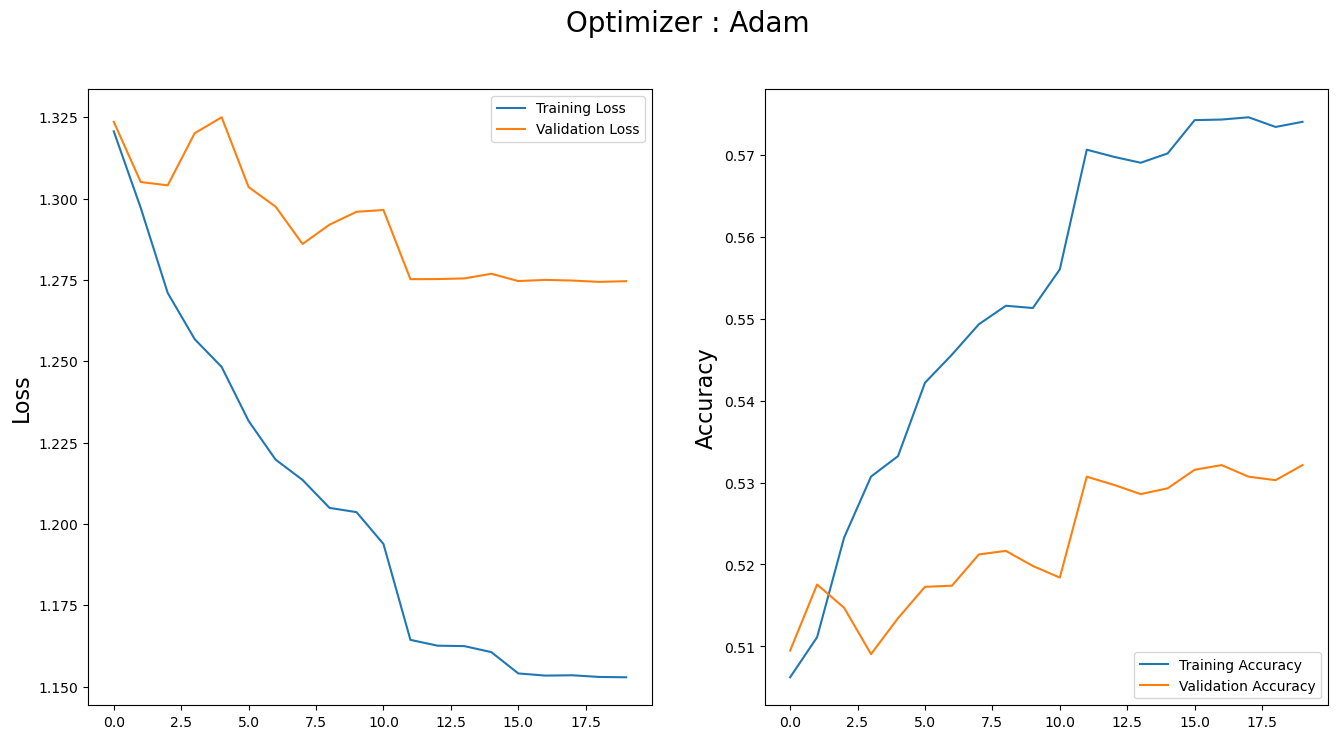

In [20]:
plot_acc(history_2)

In [21]:
y_prob2 = model_2.predict(test_ds)
y_pred2 = np.argmax(y_prob2, axis = 1)

56/56 [==============================] - 64s 1s/step


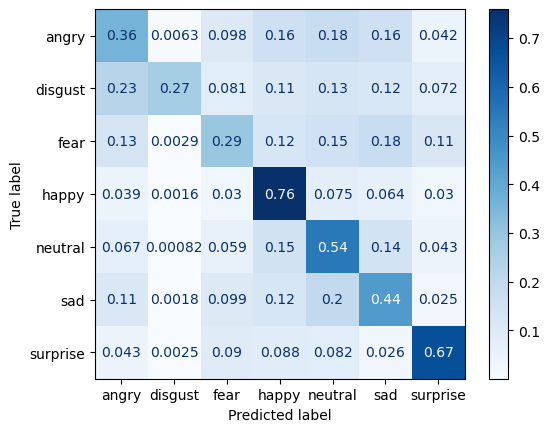

In [36]:
# confusion matrix
cm2 = confusion_matrix(y_test, y_pred2, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = labels)
disp2.plot(cmap=plt.cm.Blues)

### Result

The result for the model is 53 % accuracy on the test set.

The Confusion Matrix shows that the model predicts the face exression "happy" correctly for 76 % of the test images. The expression "disgust" is only predicted correctly for 27 % of the test images.

## 4.3 Model with extra layers added

In [23]:
# add layers and output
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x)
x = Dense(1024, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs_extra = Dense(no_of_classes, activation = 'softmax')(x)
model_extra = Model(inputs, outputs_extra)

# compile
model_extra.compile(loss='categorical_crossentropy',
                    optimizer = Adam(learning_rate = 0.001),
                    metrics=['accuracy'])

In [24]:
# train (new layers only)
checkpoint_extra = ModelCheckpoint("model_extra.keras",
                                   monitor = 'val_accuracy',
                                   verbose = 1,
                                   save_best_only = True,
                                   mode = 'max')

callbacks_list_extra = [early_stopping, checkpoint_extra, reduce_learningrate]

history_extra = model_extra.fit(x = train_ds,
                                steps_per_epoch = len(train_ds),
                                epochs = epochs,
                                validation_data = test_ds,
                                validation_steps = len(test_ds),
                                callbacks = callbacks_list_extra)


Epoch 1/20
226/226 [==============================] - ETA: 0s - loss: 1.6203 - accuracy: 0.4295
Epoch 1: val_accuracy improved from -inf to 0.47990, saving model to model_extra.keras
226/226 [==============================] - 321s 1s/step - loss: 1.6203 - accuracy: 0.4295 - val_loss: 1.3962 - val_accuracy: 0.4799 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - ETA: 0s - loss: 1.3129 - accuracy: 0.5084
Epoch 2: val_accuracy improved from 0.47990 to 0.52038, saving model to model_extra.keras
226/226 [==============================] - 321s 1s/step - loss: 1.3129 - accuracy: 0.5084 - val_loss: 1.3205 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.5422
Epoch 3: val_accuracy improved from 0.52038 to 0.53609, saving model to model_extra.keras
226/226 [==============================] - 329s 1s/step - loss: 1.2140 - accuracy: 0.5422 - val_loss: 1.2850 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 4/20

In [ ]:
# model_extra = load_model('model_extra.keras')

### 4.3.1 Accuracy & Loss and Confusion Matrix

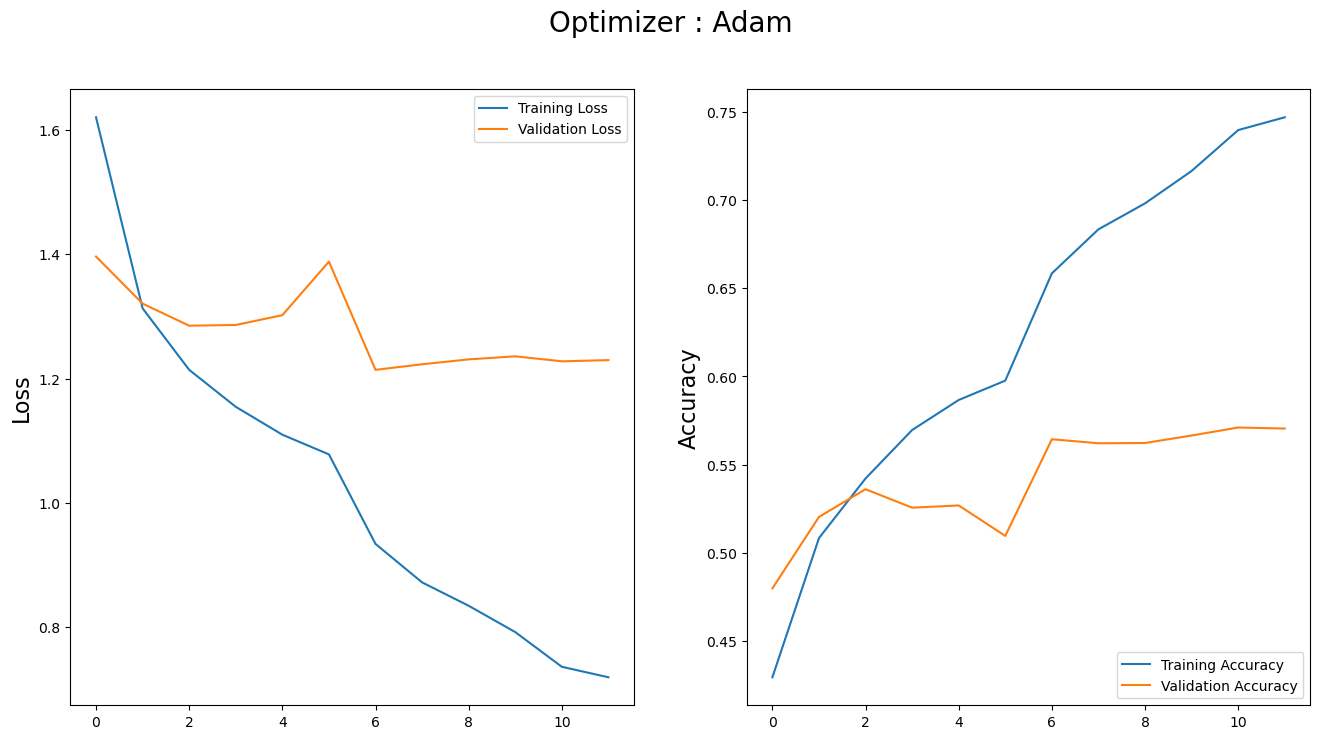

In [25]:
plot_acc(history_extra)

In [26]:
y_pred_prob_extra = model_extra.predict(test_ds)
y_pred_extra = np.argmax(y_pred_prob_extra, axis = 1)

56/56 [==============================] - 57s 1s/step


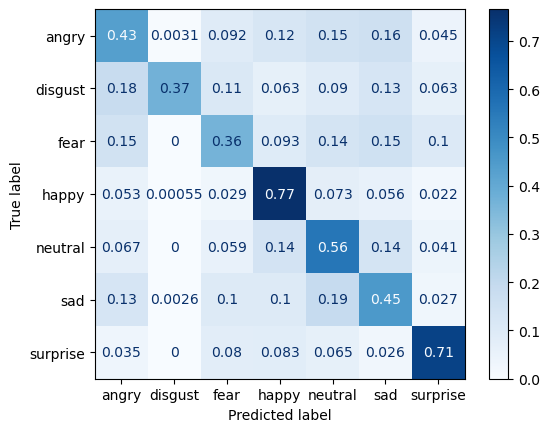

In [38]:
# confusion matrix
cm_extra = confusion_matrix(y_test, y_pred_extra, normalize='true')
disp_extra = ConfusionMatrixDisplay(confusion_matrix = cm_extra, display_labels = labels)
disp_extra.plot(cmap=plt.cm.Blues)

### Result

The result for the model is 57 % accuracy on the test set.

The Confusion Matrix shows that the model predicts the face exression "happy" correctly for 77 % of the test images. The expressions "disgust" and "fear" are only predicted correctly for about 37 % of the test images.

## 4.4 Fine-tuning final layers

In [28]:
base = MobileNetV2(include_top = False,
                   input_shape = (224, 224, 3),
                   weights='imagenet',
                   pooling = 'avg')
base.trainable = True

In [ ]:
# base.summary()

In [29]:
for layer in base.layers[:150]:
    layer.trainable = False

In [30]:
# Model
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base(x)
outputs = Dense(no_of_classes, activation = 'softmax')(x)
model_fine = Model(inputs, outputs)


# compile
model_fine.compile(loss='categorical_crossentropy',
                   optimizer = Adam(learning_rate = 0.001),
                   metrics=['accuracy'])

In [31]:
chkpnt = ModelCheckpoint("model_fine.keras",
                         monitor = 'val_accuracy',
                         verbose = 1,
                         save_best_only = True,
                         mode = 'max')

callbacks = [early_stopping, chkpnt, reduce_learningrate]

history_fine = model_fine.fit(x = train_ds,
                              steps_per_epoch = len(train_ds),
                              epochs = epochs,
                              validation_data = test_ds,
                              validation_steps = len(test_ds),
                              callbacks = callbacks)

Epoch 1/20
226/226 [==============================] - ETA: 0s - loss: 1.3585 - accuracy: 0.4973
Epoch 1: val_accuracy improved from -inf to 0.52194, saving model to model_fine.keras
226/226 [==============================] - 319s 1s/step - loss: 1.3585 - accuracy: 0.4973 - val_loss: 1.3596 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 2/20
226/226 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.6096
Epoch 2: val_accuracy did not improve from 0.52194
226/226 [==============================] - 335s 1s/step - loss: 1.0539 - accuracy: 0.6096 - val_loss: 1.4015 - val_accuracy: 0.5173 - lr: 0.0010
Epoch 3/20
226/226 [==============================] - ETA: 0s - loss: 0.9202 - accuracy: 0.6656
Epoch 3: val_accuracy improved from 0.52194 to 0.54826, saving model to model_fine.keras
226/226 [==============================] - 336s 1s/step - loss: 0.9202 - accuracy: 0.6656 - val_loss: 1.3350 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 4/20
226/226 [==============================]

In [ ]:
# model_fine = load_model('model_fine.keras')

### 4.4.1 Accuracy & Loss and Confusion Matrix

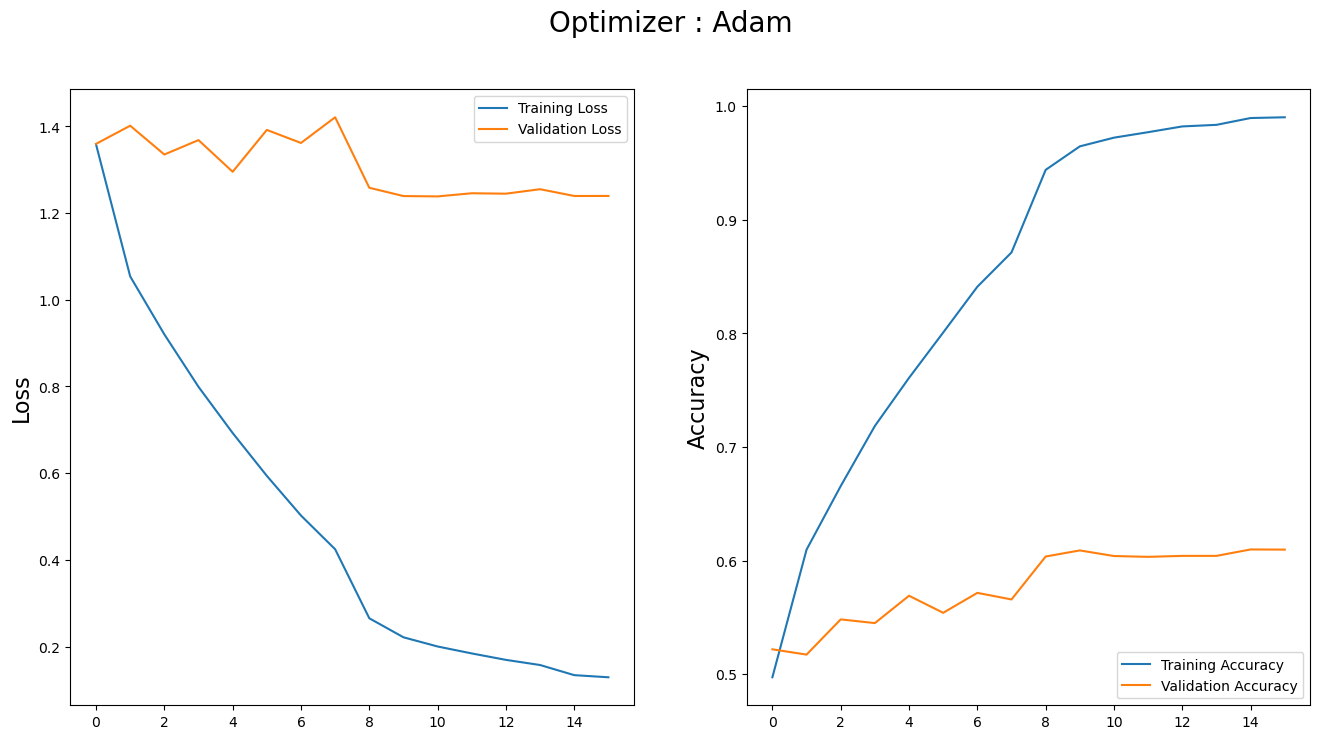

In [32]:
plot_acc(history_fine)

In [33]:
y_prob_ft = model_fine.predict(test_ds)
y_pred_ft = np.argmax(y_prob_ft, axis = 1)

56/56 [==============================] - 58s 1s/step


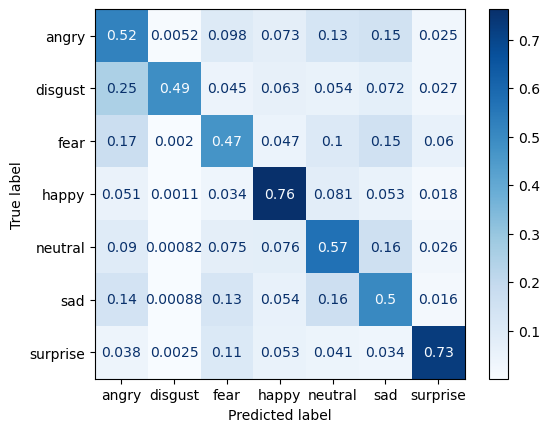

In [39]:
# confusion matrix
cm_ft = confusion_matrix(y_test, y_pred_ft, normalize='true')
disp_ft = ConfusionMatrixDisplay(confusion_matrix = cm_ft, display_labels = labels)
disp_ft.plot(cmap=plt.cm.Blues)

### Result

The result for the model is 61 % accuracy on the test set.

The Confusion Matrix shows that the model predicts the face exression "happy" correctly for 76 % of the test images. The expression "fear" is only predicted correctly for 47 % of the test images.

# 5 Conclusions

The model made from scratch gets a better overall accuracy score on the test set. After experimenting with different setups with the pre-trained model it still doesn't get a better ovarall score. But the fine-tuned model gets a more evenly spread accuracy among the different expressions (47-76%).

With more data augmentation and better fine-tuning it's likely to further improve the accuracy.

The computations are made on a CPU which made the process slow. With a GPU the process would have been much faster, enabling more attempts and more epochs.

The model made from scratch and the fine-tuned model will be put to the test by comparing the predictions of the two with a Streamlit-app. 

# 6 Reflektioner

När du är klar med koden skall du i slutet av skriptet besvara följande frågeställningar:

### 1 Utmaningar du haft under arbetet samt hur du hanterat dem.


Det har varit svårt att få tillgång till GPU via Google Colab, därmed har modellberäkningarna gjorts med CPU. För att beräkningarna inte ska bli orimligt tidskrävande har jag minskat antalet epoker. Detta kan ha resulterat i lägre "accuracy" för modellerna. Men eftersom CPU är använt för beräkning av samtliga modeller så kan ändå resultaten vara jämförbara.

### 2 Vilket betyg du anser att du skall ha och varför.

Jag tycker att jag uppfyller VG-kraven.

### 3 Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den.

Laborera mer! Testa olika lösningar och jämför resultaten. Försöka dra slutsatser kring likheterna/olikheterna av resultaten.